Import bibliotek

In [1]:

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, make_scorer, fbeta_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
from time import time
import scikitplot as skplt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import warnings
import plotly.express as px
import sort_dataframeby_monthorweek as sd

sns.set(style = "darkgrid")
random_state=42

Wczytywanie i czyszczenie danych

In [2]:
data_df = pd.read_csv("hotel_bookings.csv")
pd.set_option("display.float_format", lambda x: "%.5f" % x)

#usuwanie niepotrzebnych kolumn
data_df = data_df.drop(columns=["reservation_status_date", "hotel", "reservation_status",
    "arrival_date_week_number", "reserved_room_type", "company"])

#usuwanie wierszy w których liczba gości wynosiła 0
filter = (data_df.children == 0) & (data_df.adults == 0) & (data_df.babies == 0)
data_df[filter]
data_df = data_df[~filter]
data_df=data_df.replace(" ","_")
data_df = data_df.reindex(data_df.columns.tolist(), axis = 1)

# usuwanie NaNów
nan_replacements = {"children": 0.0, "agent": 0, "country": "unknown"}
data_df = data_df.fillna(nan_replacements)

Analiza danych

In [3]:
data_df.columns

Index(['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'assigned_room_type',
       'booking_changes', 'deposit_type', 'agent', 'days_in_waiting_list',
       'customer_type', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests'],
      dtype='object')

In [4]:
#lista miesięcy w odpowiedniej kolejności
lista = list(data_df['arrival_date_month'].unique())
lista = ['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

In [5]:
data_df2 = data_df.drop(data_df[data_df['adr']==5400].index, axis=0, inplace=False)
d = data_df2.groupby(['arrival_date_month'])['adr'].mean().reset_index()
d['arrival_date_month'] = pd.Categorical(d['arrival_date_month'], categories=lista, ordered=True)
d.sort_values('arrival_date_month', inplace=True)

Text(0.5, 1.0, 'Średnia dzienna cena pokoju na miesiąc')

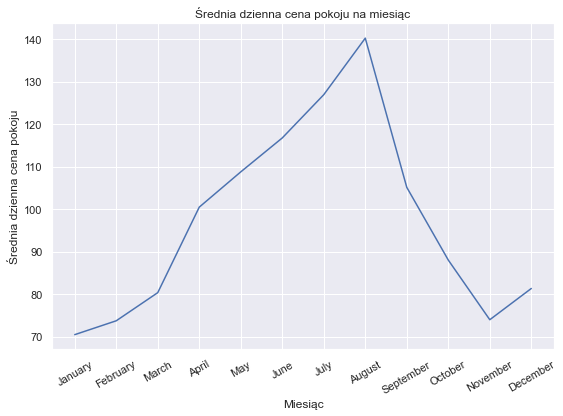

In [6]:
plt.figure(figsize=(9,6))
sns.lineplot(x='arrival_date_month', y='adr', data=d)
plt.ylabel("Średnia dzienna cena pokoju")
plt.xlabel("Miesiąc")
p = plt.xticks(rotation=30)
plt.title("Średnia dzienna cena pokoju na miesiąc")

Text(0, 0.5, 'Ilość rezerwacji')

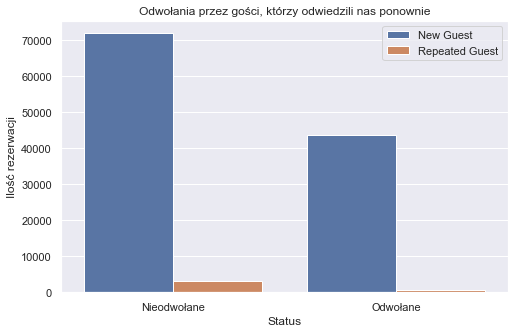

In [7]:
plt.figure(figsize=(8,5))
sns.countplot(x = "is_canceled", hue = 'is_repeated_guest', data = data_df)
plt.legend(['New Guest', 'Repeated Guest'])
plt.xticks(ticks=[0,1], labels=['Nieodwołane', 'Odwołane'])
plt.title("Odwołania przez gości, którzy odwiedzili nas ponownie")
plt.xlabel("Status")
plt.ylabel("Ilość rezerwacji")

In [8]:
data_df[["is_canceled",'deposit_type', "arrival_date_month"]].groupby(by=["is_canceled",'deposit_type']).count()

arrival_date_month
is_canceled deposit_type                    
0           No Deposit                 74792
            Non Refund                    93
            Refundable                   126
1           No Deposit                 29669
            Non Refund                 14494
            Refundable                    36

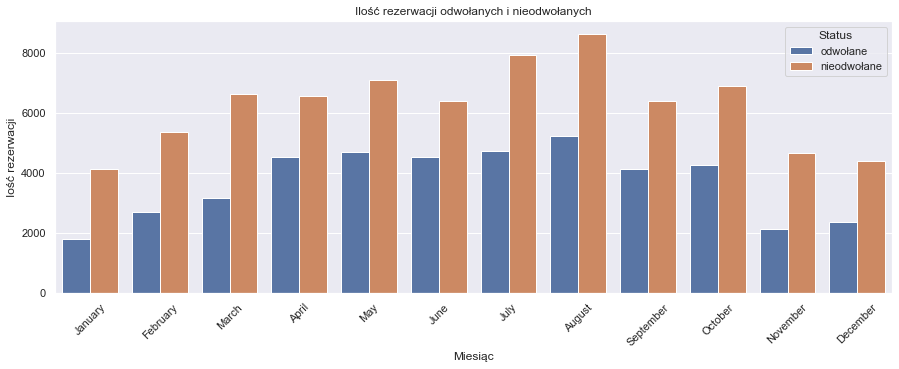

In [9]:
odwolane = data_df[data_df['is_canceled'] == 1]
nieodwolane = data_df[data_df['is_canceled'] == 0]

odwolane = odwolane.groupby(["arrival_date_month"])["is_canceled"].agg('count').reset_index()
odwolane["status"] = 'odwołane'
# odwolane
nieodwolane = nieodwolane.groupby(["arrival_date_month"])["is_canceled"].agg('count').reset_index()
nieodwolane["status"] = "nieodwołane"
# nieodwolane
all = pd.concat([odwolane[["arrival_date_month","is_canceled",'status']], nieodwolane[["arrival_date_month","is_canceled",'status']]])
all

plt.figure(figsize=(15, 5))
plt.title("Ilość rezerwacji odwołanych i nieodwołanych")
plt.xlabel("miesiąc")
plt.ylabel("Iość rezerwacji")
sns.barplot(x="arrival_date_month", y ="is_canceled", hue="status", data=all, order=lista)
plt.xlabel("Miesiąc")
plt.ylabel("Iość rezerwacji")
plt.legend(title="Status")
plt.xticks(rotation=45);


Zamiana zmiennych kategorycznych na numeryczne

In [10]:
features = data_df.drop(columns=["is_canceled"], axis=1).columns
# features

In [11]:
x = data_df[features]
y = data_df["is_canceled"]

In [12]:
# do każdej zmiennej użyto innego LabelEncodera żeby potem można było zamienić zmienne numeryczne na odpowiednie zmienne kategoryczne
object_v = []
for i in x:
    if x[i].dtype == object:
        object_v.append(i)

le1 = LabelEncoder()
le2 = LabelEncoder()
le3 = LabelEncoder()
le4 = LabelEncoder()
le5 = LabelEncoder()
le6 = LabelEncoder()
le7 = LabelEncoder()
le8 = LabelEncoder()

encoders = [le1, le2, le3, le4, le5, le6, le7, le8]

def en(enc, var):
    enc.fit(x[var])
    tmp_s = enc.transform(x[var]).reshape((-1,1))
    x[var] = pd.DataFrame(tmp_s)

for j in range(len(encoders)):
    c = object_v[j]
    en(encoders[j], c)

x=x.fillna(0).astype(int)

C:\Users\iwona\AppData\Local\Temp/ipykernel_2068/3110934825.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[var] = pd.DataFrame(tmp_s)


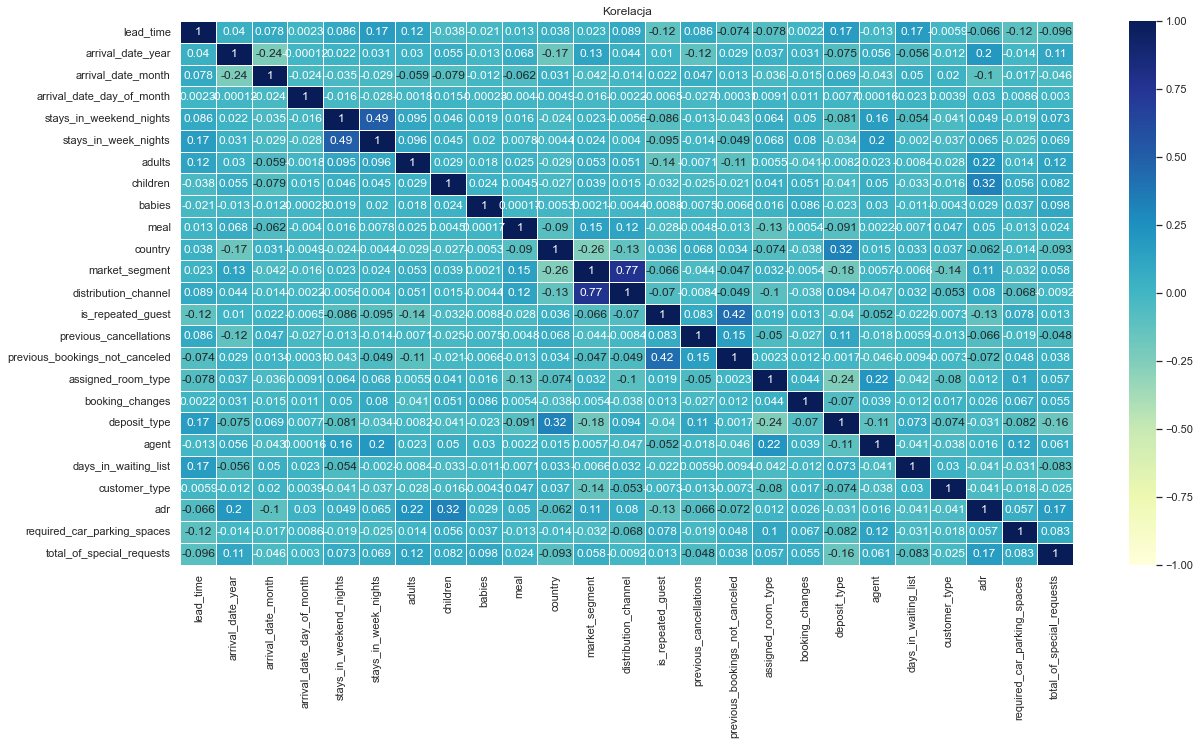

In [13]:
plt.rcParams["figure.figsize"]=(20,10)
plt.title('Korelacja')
sns.heatmap(x.corr(method="pearson",), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="YlGnBu");

### Wybór najlepszego modelu

In [14]:

models = [("Dummy_Model",DummyClassifier(strategy="stratified")),
            ("DecisionTree_Model", DecisionTreeClassifier(random_state=42)),
            ("RandomForest_Model", RandomForestClassifier(random_state=42)),
            ("LogisticRegression_Model", LogisticRegression(random_state=42, solver="liblinear")),
            ("XGBBoost_Model", XGBClassifier(random_state=42,use_label_encoder=False, eval_metric="mlogloss", n_jobs=-1)),
            ("Gaussian_Model", GaussianNB()),
            ("KNN_Model", KNeighborsClassifier())]

split = KFold(n_splits=4, shuffle=True, random_state=42)
fbeta_scorer = make_scorer(fbeta_score, beta=0.5)

In [15]:
for name, model in models:
    start = time()
    cv_results = cross_val_score(model, x, y, cv=split, scoring="accuracy")
    fbeta_res = cross_val_score(model, x, y, cv=split, scoring=fbeta_scorer)
    mean_score = round(np.mean(cv_results), 4)
    fbeta_score = round(np.mean(fbeta_res), 4)
    end = time()
    cross_val_time = round(end-start,4)
    print(f"{name}  f-beta: {fbeta_score}, accuracy score: {mean_score}, time: {cross_val_time}")

Dummy_Model  f-beta: 0.3686, accuracy score: 0.5314, time: 0.1641
DecisionTree_Model  f-beta: 0.7662, accuracy score: 0.8285, time: 4.3705
RandomForest_Model  f-beta: 0.8654, accuracy score: 0.8807, time: 80.3573
LogisticRegression_Model  f-beta: 0.7259, accuracy score: 0.7805, time: 9.2199
XGBBoost_Model  f-beta: 0.8411, accuracy score: 0.8685, time: 14.573
Gaussian_Model  f-beta: 0.4928, accuracy score: 0.5352, time: 0.5559
KNN_Model  f-beta: 0.6858, accuracy score: 0.7645, time: 310.8423


Wizualizacja wyników

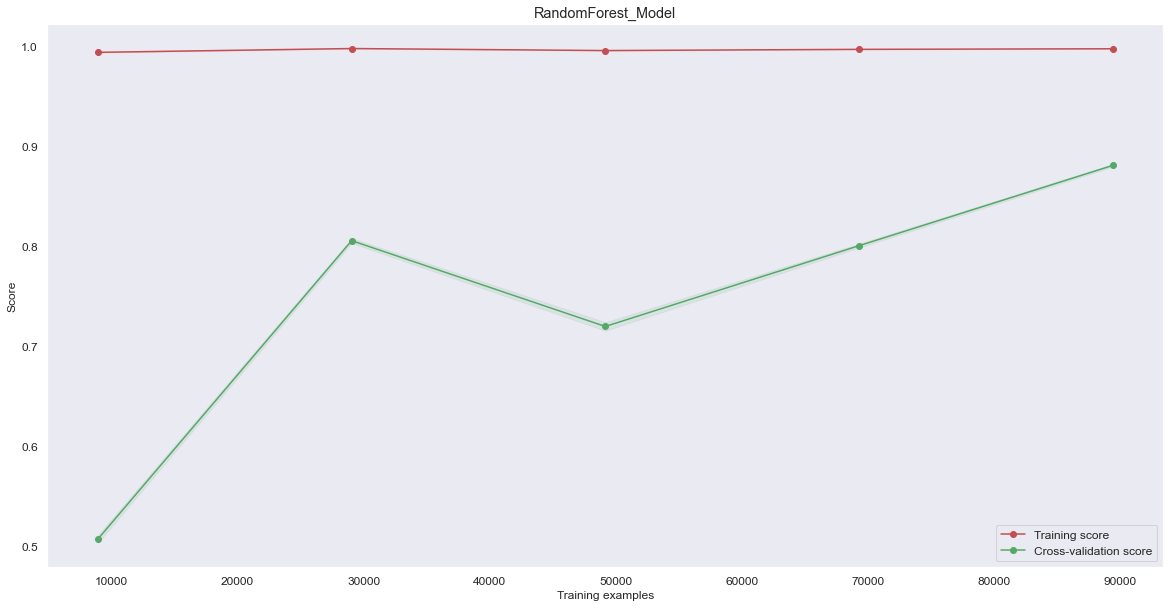

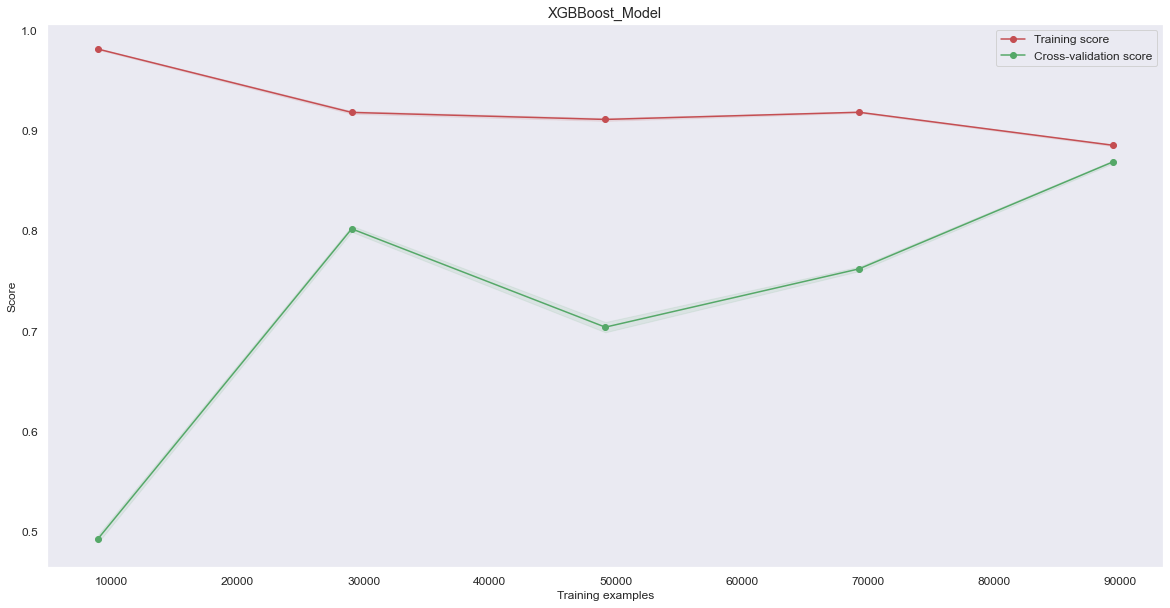

In [16]:
# krzywe trenowania madeli
for name, model in models:
    if name == "RandomForest_Model" or name == "XGBBoost_Model":
        skplt.estimators.plot_learning_curve(model, x, y,name, cv=split)
        plt.show()

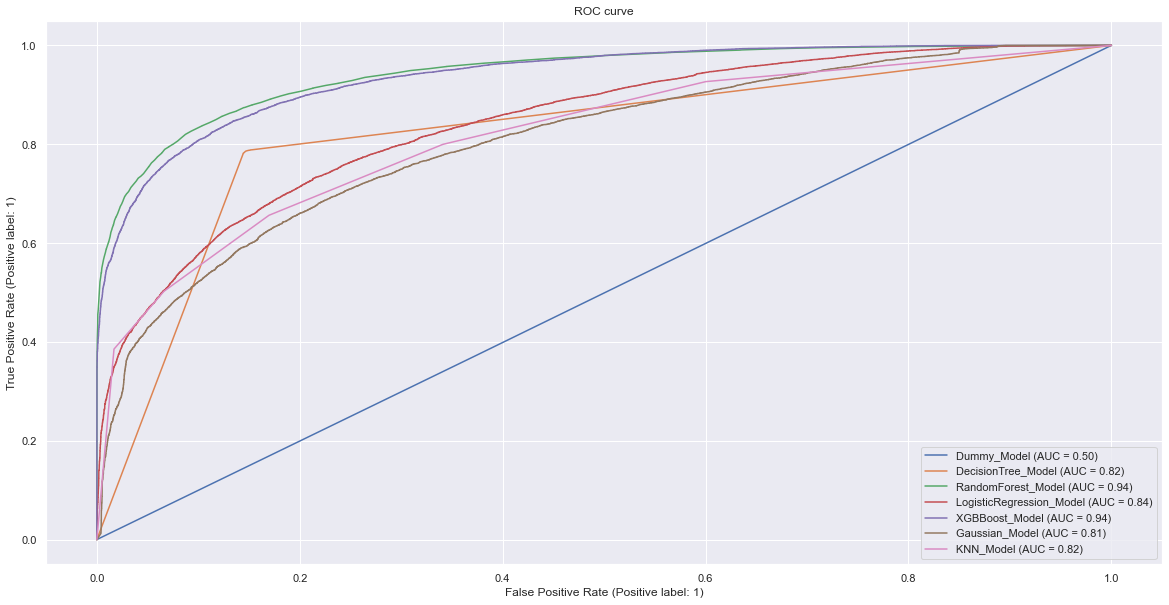

In [17]:
# krzywe roc
warnings.filterwarnings("ignore")

x1 = np.array(x)
y1= np.array(y)

fig, ax = plt.subplots()

for name, model in models:
    for i, (train, test) in enumerate(split.split(x1)):
        if i == 3:
            x1_train, x1_test = x1[train], x1[test]
            y1_train, y1_test = y1[train], y1[test]
            fit = model.fit(x1[train], y1[train])
            plot_roc_curve(model, x1_test, y1_test, ax=ax, name=name)
_ = ax.set_title("ROC curve")

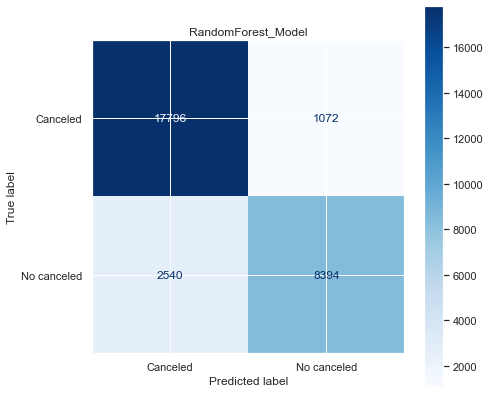

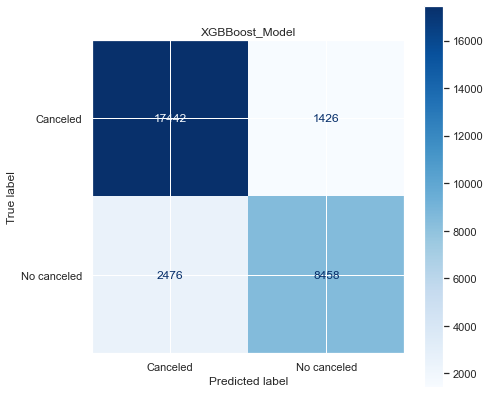

In [18]:
# macierze pomyłek
for name, model in models:
    plt.rcParams["figure.figsize"]=(7,7)
    if name == "RandomForest_Model" or name == "XGBBoost_Model":
        plot_confusion_matrix(model, x1_test, y1_test,display_labels=['Canceled','No canceled'],cmap=plt.cm.Blues)
        plt.title(f"{name}")
        plt.show()

### Najważniejsze zmienne dla modelu Random Forest 

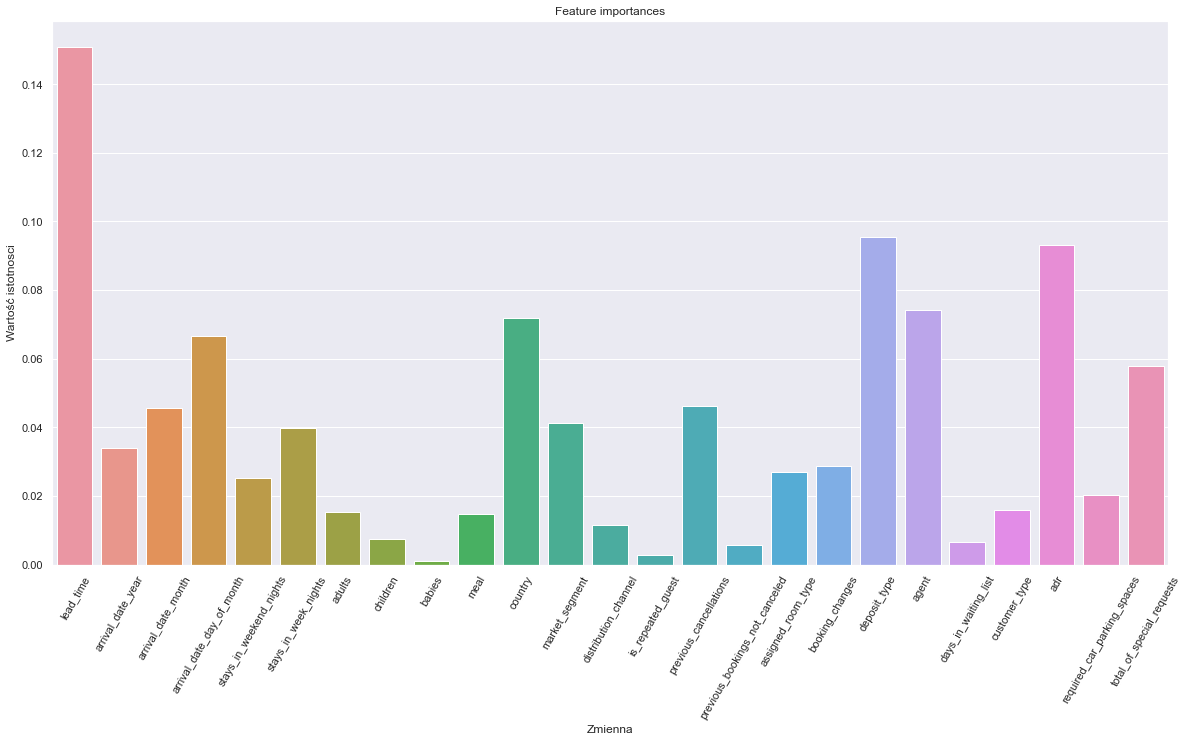

In [19]:
model = RandomForestClassifier(n_estimators=100)
model.fit(x, y)
rf = pd.DataFrame({"Zmienna" : x.columns,
              "Wartość istotnosci": model.feature_importances_})
plt.figure(figsize=(20,10))
plt.title('Feature importances')
sns.set(style="whitegrid")
ax = sns.barplot(x="Zmienna", y="Wartość istotnosci", data=rf)
for label in ax.get_xticklabels():
    label.set_rotation(60)

### Optymalizacja modelu **Random Forest**

In [20]:
# feature importances > 0,2
x_rf = x[['lead_time','arrival_date_year','arrival_date_month','arrival_date_day_of_month','stays_in_week_nights','stays_in_weekend_nights',
    'country','market_segment','previous_cancellations','assigned_room_type','booking_changes','deposit_type','adr','agent','total_of_special_requests',
    'required_car_parking_spaces']]

model_o = RandomForestClassifier(n_estimators=100)

start_rf = time()
cv_results_rf = cross_val_score(model_o, x_rf, y, cv=split, scoring="accuracy")
fbeta_res_rf = cross_val_score(model_o, x_rf, y, cv=split, scoring=fbeta_scorer)
mean_score_rf = round(np.mean(cv_results_rf), 4)
fbeta_score_rf = round(np.mean(fbeta_res_rf), 4)
end_rf = time()
cross_val_time_rf = round(end_rf-start_rf,4)
print(f"Random Forest model: f-beta: {fbeta_score_rf}, accuracy score: {mean_score_rf}, time: {cross_val_time_rf}")

Random Forest model: f-beta: 0.864, accuracy score: 0.8801, time: 75.4341


In [21]:
# zmiana hiperparametrów
my_model = RandomForestClassifier(max_depth=None, min_samples_leaf=2, n_jobs=1, random_state=100, max_features='sqrt', n_estimators=200)

start_rf = time()
cv_results_rf = cross_val_score(my_model, x_rf, y, cv=split, scoring="accuracy")
fbeta_res_rf = cross_val_score(my_model, x_rf, y, cv=split, scoring=fbeta_scorer)
mean_score_rf = round(np.mean(cv_results_rf), 4)
fbeta_score_rf = round(np.mean(fbeta_res_rf), 4)
end_rf = time()
cross_val_time_rf = round(end_rf-start_rf,4)
print(f"Random Forest model: f-beta: {fbeta_score_rf}, accuracy score: {mean_score_rf}, time: {cross_val_time_rf}")

Random Forest model: f-beta: 0.8621, accuracy score: 0.8786, time: 144.4423


Symulacja biznesowa

In [22]:
warnings.filterwarnings("ignore")
x_s = np.array(x_rf)
y_s= np.array(y)

model_s = RandomForestClassifier(n_estimators=100)

for train, test in split.split(x_s):
    x_train, x_test = x_s[train], x_s[test]
    y_train, y_test = y_s[train], y_s[test]
    fit = model_s.fit(x_s[train], y_s[train])
    y_pred = model_s.predict(x_test)

In [23]:
features_s = ['lead_time','arrival_date_year','arrival_date_month','arrival_date_day_of_month','stays_in_week_nights','stays_in_weekend_nights',
    'country','market_segment','previous_cancellations','assigned_room_type','booking_changes','deposit_type','adr','agent','total_of_special_requests',
    'required_car_parking_spaces']

In [24]:
symulacja = pd.DataFrame(x_test, columns=features_s)
symulacja.head()

,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_week_nights,stays_in_weekend_nights,country,market_segment,previous_cancellations,assigned_room_type,booking_changes,deposit_type,adr,agent,total_of_special_requests,required_car_parking_spaces
0,7,2015,5,1,1,0,59,3,0,2,0,0,75,0,0,0
1,14,2015,5,1,2,0,59,6,0,0,0,0,98,240,1,0
2,37,2015,5,1,4,0,135,6,0,4,0,0,94,241,0,0
3,68,2015,5,1,4,0,76,6,0,4,0,0,97,240,3,0
4,37,2015,5,1,4,0,135,5,0,4,0,0,97,8,0,0


In [25]:
# zamaiana zmiennych numerycznych na kategoryczne
def inv(var, enc):
    symulacja[var] = enc.inverse_transform(symulacja[var])

In [26]:
object_s = ['arrival_date_month', 'country', 'market_segment', 'assigned_room_type', 'deposit_type']
encoders_s = [le1, le3, le4, le6, le7]

In [27]:
for k in range(len(encoders_s)):
    z = object_s[k]
    inv(z, encoders_s[k])

In [28]:
sym = {"wartości rezczywiste": y_test,
        "wartości przewidziane": y_pred}

sym_df = pd.DataFrame(sym)
sym_df = sym_df.join(symulacja)
# sym_df
sym_df['deposit_type'].value_counts()

No Deposit    26124
Non Refund     3640
Refundable       38
Name: deposit_type, dtype: int64

In [29]:
# funkcja która posortuje miesiące w tabeli
def sort_month(df, column_name):
    return sd.Sort_Dataframeby_Month(df, column_name)

In [31]:
# srednia cena za dany miesiąc za noc od osoby
cena_za_miesiac = data_df.groupby(['arrival_date_month'])['adr'].mean().reset_index()
cena_za_miesiac.columns = ['month', 'price']
cena_za_miesiac = sort_month(cena_za_miesiac, 'month')
# cena_za_miesiac
# uzyskany przychód w przypadku gdy nikt nie odwola rezerwacji
liczba_gosci = sym_df['arrival_date_month'].value_counts().reset_index()
liczba_gosci.columns=['month','no of guests']
liczba_gosci = sort_month(liczba_gosci,'month')
# liczba_gosci
final = cena_za_miesiac.merge(liczba_gosci,on='month')
final.columns=['month','cena za miesiąc', 'liczba zajetych pokoi']
final["cena_calkowita"] = final['cena za miesiąc'] * final['liczba zajetych pokoi']
final["status"]  = "overall"
# final
# podział danych na odwołane i nieodwołalne rezerwacje
odwolane = sym_df[sym_df['wartości przewidziane'] == 1]
nieodwolane = sym_df[sym_df['wartości przewidziane'] == 0]
# uzyskany przychód w przypadku gdy wszyscy przewidziani odwołają
liczba_gosci = nieodwolane['arrival_date_month'].value_counts().reset_index()
liczba_gosci.columns=['month','liczba zajetych pokoi']
liczba_gosci = sort_month(liczba_gosci,'month')
# liczba_gosci
final_nieodwolane = cena_za_miesiac.merge(liczba_gosci,on='month')
final_nieodwolane.columns=['month','cena za miesiąc', 'liczba zajetych pokoi']
final_nieodwolane["cena_calkowita"] = final_nieodwolane['cena za miesiąc'] * final_nieodwolane['liczba zajetych pokoi']
final_nieodwolane["status"]  = "non calceled"
# final_nieodwolane
# goście którzy odwołują ale zapłacili bezzwrotną zaliczkę 30%
odwolane_z_depozytem = odwolane[odwolane['deposit_type'] == 'Non Refund']
# odwolane_z_depozytem
cena_za_miesiac['price'] = cena_za_miesiac['price']*0.3
# cena_za_miesiac
liczba_gosci = odwolane_z_depozytem['arrival_date_month'].value_counts().reset_index()
liczba_gosci.columns=['month','liczba zajetych pokoi']
liczba_gosci = sort_month(liczba_gosci,'month')
# liczba_gosci
final_odwolane = cena_za_miesiac.merge(liczba_gosci,on='month')
final_odwolane.columns=['month','cena za miesiąc', 'liczba zajetych pokoi']
final_odwolane["cena_calkowita"] = final_odwolane['cena za miesiąc'] * final_odwolane['liczba zajetych pokoi']
final_odwolane["status"]  = "non calceled"
# final_odwolane
# dodaje tych z zaliczką bezzwrotną do tych który nie odwołają
z_zaliczka = final_odwolane[['month','cena_calkowita']]

z_zaliczka = z_zaliczka.merge(final_nieodwolane[['month','cena_calkowita']], on='month')
z_zaliczka['cena_calkowita'] = z_zaliczka['cena_calkowita_x'] + z_zaliczka['cena_calkowita_y']
z_zaliczka_new = z_zaliczka[['month','cena_calkowita']]
z_zaliczka_new["status"]  = "non calceled + non refund deposit"
# z_zaliczka_new
porownanie_1 = pd.concat([final[['month','cena_calkowita','status']], (z_zaliczka_new[['month','cena_calkowita','status']])])
# porowniae_1
#załózmy ze do wszystkich pozostalych dodajmemy zaliczke
sym_1 = odwolane
# sym_1
liczba_gosci = sym_1['arrival_date_month'].value_counts().reset_index()
liczba_gosci.columns=['month','liczba zajetych pokoi']
liczba_gosci = sort_month(liczba_gosci,'month')
# liczba_gosci
final_sym1 = cena_za_miesiac.merge(liczba_gosci,on='month')
final_sym1.columns=['month','cena za miesiąc', 'liczba zajetych pokoi']
final_sym1["cena_calkowita"] = final_sym1['cena za miesiąc'] * final_sym1['liczba zajetych pokoi']
final_sym1["status"]  = "extra depisit"
# final_sym1
# dodaje do wszystkich nieodwołanych zaliczke bezzwrotną od wszystkich odwołanych
wymagana_zaliczka = final_sym1[['month','cena_calkowita']]
wymagana_zaliczka = wymagana_zaliczka.merge(final_nieodwolane[['month','cena_calkowita']], on='month')
wymagana_zaliczka['cena_calkowita'] = wymagana_zaliczka['cena_calkowita_x'] + wymagana_zaliczka['cena_calkowita_y']
wymagana_zaliczka_new = wymagana_zaliczka[['month','cena_calkowita']]
wymagana_zaliczka_new["status"]  = "non calceled + non refund deposit + extra deposit"
# wymagana_zaliczka_new
porownanie_2 = pd.concat([porownanie_1[['month','cena_calkowita','status']], wymagana_zaliczka_new[['month','cena_calkowita','status']]])
# porownanie_2
# ci którzy odwołali na wiecej niż 14 dni przed przyjazdem
odwolane_dlugi_lead_lime = odwolane[odwolane['lead_time'] >= 14]
# odwolane_dlugi_lead_lime
# na zwolnione miejsca robimy zniżke 25%
cena_za_miesiac = data_df.groupby(['arrival_date_month'])['adr'].mean().reset_index()
cena_za_miesiac.columns = ['month', 'price']
cena_za_miesiac = sort_month(cena_za_miesiac, 'month')
cena_za_miesiac['price'] = cena_za_miesiac['price']*0.75
# cena_za_miesiac
# załóżmy ze tylko połowa poki została zarezerwowana
liczba_gosci = odwolane_dlugi_lead_lime['arrival_date_month'].value_counts().reset_index()
liczba_gosci.columns=['month','liczba zajetych pokoi']
liczba_gosci = sort_month(liczba_gosci,'month')
liczba_gosci['liczba zajetych pokoi'] = liczba_gosci['liczba zajetych pokoi']*0.50
# liczba_gosci
final_sym2 = cena_za_miesiac.merge(liczba_gosci,on='month')
final_sym2.columns=['month','cena za miesiąc', 'liczba zajetych pokoi']
final_sym2["cena_calkowita"] = final_sym2['cena za miesiąc'] * final_sym2['liczba zajetych pokoi']
final_sym2["status"]  = "25% discount"
# final_sym2
znizka_25 = final_sym2[['month','cena_calkowita']]
znizka_25 = znizka_25.merge(wymagana_zaliczka_new[['month','cena_calkowita']], on='month')
znizka_25['cena_calkowita'] = znizka_25['cena_calkowita_x'] + znizka_25['cena_calkowita_y']
znizka_25_new = znizka_25[['month','cena_calkowita']]
znizka_25_new["status"]  = "non calceled + non refund deposit + extra deposit + 25% discount"
# znizka_25_new
porownanie_3 = pd.concat([porownanie_2[['month','cena_calkowita','status']], znizka_25_new[['month','cena_calkowita','status']]])
# porownanie_3
# ci którzy odwolali na mniej niz 14 przed przyjazdem
odwolane_krotki_lead_lime = odwolane[odwolane['lead_time'] < 14]
# odwolane_krotki_lead_lime
# na zwolnione miejsca robimy znizke 50%
cena_za_miesiac = data_df.groupby(['arrival_date_month'])['adr'].mean().reset_index()
cena_za_miesiac.columns = ['month', 'price']
cena_za_miesiac = sort_month(cena_za_miesiac, 'month')
cena_za_miesiac['price'] = cena_za_miesiac['price']*0.50
# cena_za_miesiac
# zalozmy ze tylko polowa pokoi została zarezerwowana
liczba_gosci = odwolane_krotki_lead_lime['arrival_date_month'].value_counts().reset_index()
liczba_gosci.columns=['month','liczba zajetych pokoi']
liczba_gosci = sort_month(liczba_gosci,'month')
liczba_gosci['liczba zajetych pokoi'] = liczba_gosci['liczba zajetych pokoi']*0.50
# liczba_gosci
final_sym3 = cena_za_miesiac.merge(liczba_gosci,on='month')
final_sym3.columns=['month','cena za miesiąc', 'liczba zajetych pokoi']
final_sym3["cena_calkowita"] = final_sym2['cena za miesiąc'] * final_sym3['liczba zajetych pokoi']
final_sym3["status"]  = "50% discount"
# final_sym3

znizka_50 = final_sym3[['month','cena_calkowita']]
znizka_50 = znizka_50.merge(znizka_25_new[['month','cena_calkowita']], on='month')
znizka_50['cena_calkowita'] = znizka_50['cena_calkowita_x'] + znizka_50['cena_calkowita_y']
znizka_50_new = znizka_50[['month','cena_calkowita']]
znizka_50_new["status"]  = "non calceled + non refund deposit + extra deposit + 25% discount + 50% discount"
# f3_new

porownanie_4 = pd.concat([porownanie_3[['month','cena_calkowita','status']], znizka_50_new[['month','cena_calkowita','status']]])
porownanie_4.to_csv("symulacja_4.csv")

px.bar(porownanie_4, x = 'month', y = ['cena_calkowita'], color='status', barmode='group')